In [28]:
import os, re
import pandas as pd
from datetime import datetime

# >>> set your transcripts folder <<<
transcript_dir = r"C:\Users\User\Documents\Thesis\SUS_evaluation\gpt_transcripts"

# Output path (saved inside the same folder)
conversations_csv = os.path.join(transcript_dir, "gpt_conversations.csv")

rows = []
txt_files = [f for f in os.listdir(transcript_dir) if f.lower().endswith(".txt")]
if not txt_files:
    raise FileNotFoundError(f"No .txt transcripts found in: {transcript_dir}")

sep_re = re.compile(r"-{10,}")  # line of 10+ dashes marks start of convo body

for filename in sorted(txt_files):
    fp = os.path.join(transcript_dir, filename)
    # robust read
    try:
        with open(fp, "r", encoding="utf-8") as f:
            lines = f.read().splitlines()
    except UnicodeDecodeError:
        with open(fp, "r", encoding="utf-8-sig") as f:
            lines = f.read().splitlines()

    conv_id = None
    system_prompt = None
    name = None
    issue = None
    intensity = None
    conversation_started = False
    turn_index = 0

    for line in lines:
        # metadata
        if line.startswith("[SYSTEM PROMPT]:"):
            system_prompt = line.replace("[SYSTEM PROMPT]:", "").strip()
            continue
        if line.startswith("[CONVERSATION ID]:"):
            conv_id = line.split(":", 1)[1].strip()
            continue
        if line.startswith("[NAME]:"):
            parts = [p.strip() for p in line.split("|")]
            try:
                name = parts[0].replace("[NAME]:", "").strip()
                issue = parts[1].replace("[ISSUE]:", "").strip()
                intensity = parts[2].replace("[INTENSITY]:", "").strip()
            except Exception:
                pass
            continue

        # separator → start of dialogue
        if sep_re.search(line):
            conversation_started = True
            continue

        if conversation_started and line.strip():
            if ": " in line:
                speaker, text = line.split(": ", 1)
                turn_index += 1
                rows.append({
                    "conv_id": conv_id,
                    "turn_index": turn_index,
                    "timestamp": datetime.now().isoformat(timespec="seconds"),
                    "role": speaker.strip(),
                    "text": text.strip(),
                    "name": name,
                    "issue": issue,
                    "intensity": intensity,
                    "system_prompt": system_prompt,
                    "source_file": filename
                })

# Build DataFrame and save in the same folder as transcripts
df = pd.DataFrame(rows)
if df.empty:
    raise ValueError("Parsed 0 turns. Check transcript format or separator line.")
df.sort_values(["conv_id", "turn_index"], inplace=True)
df.to_csv(conversations_csv, index=False, encoding="utf-8-sig")

print(f"✅ Parsed {df['conv_id'].nunique()} conversations, {len(df)} turns")
print(f"💾 Saved: {conversations_csv}")

# Quick preview: first conversation (few rows)
first_conv = df['conv_id'].iloc[0]
preview = df[df['conv_id'] == first_conv].head(8)[
    ["conv_id","turn_index","role","text","name","issue","intensity"]
]
display(preview)

# Show the saved CSV path explicitly
print("CSV saved at:", conversations_csv)


✅ Parsed 20 conversations, 412 turns
💾 Saved: C:\Users\User\Documents\Thesis\SUS_evaluation\gpt_transcripts\gpt_conversations.csv


,conv_id,turn_index,role,text,name,issue,intensity
0,28d63587,1,MindPeace,"Thanks for sharing, Zara. I’m here to support ...",Zara,social anxiety,Moderate but affecting me
1,28d63587,2,Zara,I've been dealing with social anxiety for a wh...,Zara,social anxiety,Moderate but affecting me
2,28d63587,3,MindPeace,"Zara, thanks for sharing this with me. Given t...",Zara,social anxiety,Moderate but affecting me
3,28d63587,4,Zara,"Yes, please continue.",Zara,social anxiety,Moderate but affecting me
4,28d63587,5,MindPeace,"I appreciate your honesty, Zara. It's a lot to...",Zara,social anxiety,Moderate but affecting me
5,28d63587,6,Zara,Usually evenings are worse.,Zara,social anxiety,Moderate but affecting me
6,28d63587,7,MindPeace,"I appreciate your honesty, Zara. Given the soc...",Zara,social anxiety,Moderate but affecting me
7,28d63587,8,Zara,"Okay, makes sense.",Zara,social anxiety,Moderate but affecting me


CSV saved at: C:\Users\User\Documents\Thesis\SUS_evaluation\gpt_transcripts\gpt_conversations.csv


In [29]:
import os
import pandas as pd

pairs_csv = os.path.join(transcript_dir, "gpt_eval_pairs.csv")

# Reload in case of a fresh session
df = pd.read_csv(conversations_csv)

# Treat any role != "MindPeace" as the user
pairs = []
for conv_id, g in df.groupby("conv_id", sort=False):
    g = g.sort_values("turn_index")
    for i in range(len(g)):
        if g.iloc[i]["role"] != "MindPeace":
            user_msg = g.iloc[i]["text"]
            bot_msg = ""
            for j in range(i+1, len(g)):
                if g.iloc[j]["role"] == "MindPeace":
                    bot_msg = g.iloc[j]["text"]
                    break
            if str(user_msg).strip() and str(bot_msg).strip():
                pairs.append({
                    "conv_id": conv_id,
                    "pair_index": int(g.iloc[i]["turn_index"]),
                    "prompt": str(user_msg),
                    "model_answer": str(bot_msg),
                    "name": g.iloc[i]["name"],
                    "issue": g.iloc[i]["issue"],
                    "intensity": g.iloc[i]["intensity"]
                })

pairs_df = pd.DataFrame(pairs)
if pairs_df.empty:
    raise ValueError("No user↔MindPeace pairs formed. Check roles or transcript format.")

pairs_df.to_csv(pairs_csv, index=False, encoding="utf-8-sig")
print(f"✅ Built {len(pairs_df)} pairs from {pairs_df['conv_id'].nunique()} conversations")
pairs_df.head(8)


✅ Built 196 pairs from 20 conversations


,conv_id,pair_index,prompt,model_answer,name,issue,intensity
0,28d63587,2,I've been dealing with social anxiety for a wh...,"Zara, thanks for sharing this with me. Given t...",Zara,social anxiety,Moderate but affecting me
1,28d63587,4,"Yes, please continue.","I appreciate your honesty, Zara. It's a lot to...",Zara,social anxiety,Moderate but affecting me
2,28d63587,6,Usually evenings are worse.,"I appreciate your honesty, Zara. Given the soc...",Zara,social anxiety,Moderate but affecting me
3,28d63587,8,"Okay, makes sense.","I hear you, Zara, and I’m here with you. Given...",Zara,social anxiety,Moderate but affecting me
4,28d63587,10,Thanks for understanding.,"I hear you, Zara, and I’m here with you. It's ...",Zara,social anxiety,Moderate but affecting me
5,28d63587,12,Thanks for understanding.,"Zara, thanks for sharing this with me. It's a ...",Zara,social anxiety,Moderate but affecting me
6,28d63587,14,I feel a bit better hearing this.,"Zara, thanks for sharing this with me. Given t...",Zara,social anxiety,Moderate but affecting me
7,28d63587,16,"Yes, please continue.","I hear you, Zara, and I’m here with you. It's ...",Zara,social anxiety,Moderate but affecting me


In [30]:
import random
import pandas as pd
import os

def _clip(s, n=120):
    s = str(s or "").strip()
    return (s[:n] + "…") if len(s) > n else s

def craft_gold_concise(name, issue, intensity, user_prompt):
    """
    Short MindPeace-style reference (1–2 sentences):
    empathy opener + validate issue/intensity + tiny nudge
    """
    first = (str(name) or "friend").split()[0]
    iss = (str(issue) or "what you're facing").lower()
    inten = (str(intensity) or "").lower()
    snip = _clip(user_prompt, 120)

    openers = [
        f"{first}, I hear you.",
        f"Thanks for telling me, {first}.",
        f"I’m here with you, {first}."
    ]
    val = f"Dealing with {iss}" + (f" can feel {inten}." if inten else ".")
    reflect = f' From what you shared — “{snip}”.' if snip else ""
    nudges = [
        "We can take this one small step at a time.",
        "Let’s focus on what feels most important right now.",
        "We’ll go gently and keep it manageable."
    ]

    return f"{random.choice(openers)} {val}{reflect} {random.choice(nudges)}".strip()

def build_eval_set_from_pairs(pairs_df, target_n=20):
    if target_n >= len(pairs_df):
        gold_df = pairs_df.copy()
    else:
        items = []
        per_issue = {iss: g.reset_index(drop=True) for iss, g in pairs_df.groupby('issue', dropna=False)}
        while len(items) < target_n and any(len(g) for g in per_issue.values()):
            for iss in list(per_issue.keys()):
                g = per_issue[iss]
                if len(g) == 0:
                    continue
                items.append(g.iloc[0])
                per_issue[iss] = g.iloc[1:]
                if len(items) >= target_n:
                    break
        if len(items) < target_n:
            remaining = pairs_df.drop(pd.DataFrame(items).index, errors="ignore")
            if len(remaining) > 0:
                extra = remaining.sample(min(target_n - len(items), len(remaining)), random_state=42).to_dict("records")
                items.extend(extra)
        gold_df = pd.DataFrame(items).reset_index(drop=True)

    gold_df["gold_answer"] = gold_df.apply(
        lambda r: craft_gold_concise(r.get("name",""), r.get("issue",""), r.get("intensity",""), r.get("prompt","")),
        axis=1
    )

    eval_set = pd.DataFrame({
        "id": range(1, len(gold_df)+1),
        "prompt": gold_df["prompt"],
        "gold_answer": gold_df["gold_answer"],
        "model_answer": gold_df["model_answer"],
        "topic": gold_df.get("issue", ""),
        "difficulty": ""
    })
    return eval_set

eval_set = build_eval_set_from_pairs(pairs_df, target_n=20)  # change to a larger number to evaluate more
gold_out = os.path.join(transcript_dir, "eval_set_gold_mindpeace_concise.csv")
eval_set.to_csv(gold_out, index=False, encoding="utf-8-sig")
print("✅ Gold eval set size:", len(eval_set))
eval_set.head(8)


✅ Gold eval set size: 20


,id,prompt,gold_answer,model_answer,topic,difficulty
0,1,"My burnout symptoms is getting tough, some day...","I’m here with you, Milan. Dealing with burnout...","I hear you, Milan, and I’m here with you. Many...",burnout symptoms,
1,2,I've been dealing with generalized anxiety for...,"Noah, I hear you. Dealing with generalized anx...","I hear you, Noah, and I’m here with you. Given...",generalized anxiety,
2,3,Lately the overthinking at night has been mild...,"Milan, I hear you. Dealing with overthinking a...","Milan, thanks for sharing this with me. It's a...",overthinking at night,
3,4,"My panic feelings is getting tough, some days ...","Liam, I hear you. Dealing with panic feelings ...","I hear you, Liam, and I’m here with you. It's ...",panic feelings,
4,5,Lately the relationship worries has been chang...,"I’m here with you, Nora. Dealing with relation...","I appreciate your honesty, Nora. It's a lot to...",relationship worries,
5,6,I've been dealing with social anxiety for a wh...,"I’m here with you, Zara. Dealing with social a...","Zara, thanks for sharing this with me. Given t...",social anxiety,
6,7,Lately the stress at work has been moderate bu...,"I’m here with you, Noah. Dealing with stress a...","I hear you, Noah, and I’m here with you. Many ...",stress at work,
7,8,Lately the study pressure has been mild and ma...,"I’m here with you, Emma. Dealing with study pr...","I appreciate your honesty, Emma. It's a lot to...",study pressure,


In [31]:
import os
import pandas as pd
from sentence_transformers import SentenceTransformer, util

eval_path = os.path.join(transcript_dir, "eval_set_gold_mindpeace_concise.csv")
df_eval = pd.read_csv(eval_path).fillna("")

# Use two encoders for stability (you can keep only MiniLM to be lighter)
encoders = {
    "all-MiniLM-L6-v2": SentenceTransformer("all-MiniLM-L6-v2"),
    "all-mpnet-base-v2": SentenceTransformer("all-mpnet-base-v2")
}

for name, enc in encoders.items():
    g_emb = enc.encode(df_eval["gold_answer"].tolist(), convert_to_tensor=True, normalize_embeddings=True)
    m_emb = enc.encode(df_eval["model_answer"].tolist(), convert_to_tensor=True, normalize_embeddings=True)
    cos = util.pytorch_cos_sim(g_emb, m_emb)
    df_eval[f"sim_{name}"] = [float(cos[i, i]) for i in range(len(df_eval))]

df_eval["sim_avg_embed"] = df_eval[[f"sim_{k}" for k in encoders.keys()]].mean(axis=1)
print("Average embed similarity:", df_eval["sim_avg_embed"].mean().round(3))

sim_out = os.path.join(transcript_dir, "similarity_results.csv")
df_eval.to_csv(sim_out, index=False, encoding="utf-8-sig")
print("💾 Saved:", sim_out)
df_eval[["prompt","gold_answer","model_answer","sim_avg_embed"]].head(5)


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need

Average embed similarity: 0.652
💾 Saved: C:\Users\User\Documents\Thesis\SUS_evaluation\gpt_transcripts\similarity_results.csv


,prompt,gold_answer,model_answer,sim_avg_embed
0,"My burnout symptoms is getting tough, some day...","I’m here with you, Milan. Dealing with burnout...","I hear you, Milan, and I’m here with you. Many...",0.806709
1,I've been dealing with generalized anxiety for...,"Noah, I hear you. Dealing with generalized anx...","I hear you, Noah, and I’m here with you. Given...",0.833623
2,Lately the overthinking at night has been mild...,"Milan, I hear you. Dealing with overthinking a...","Milan, thanks for sharing this with me. It's a...",0.606104
3,"My panic feelings is getting tough, some days ...","Liam, I hear you. Dealing with panic feelings ...","I hear you, Liam, and I’m here with you. It's ...",0.764017
4,Lately the relationship worries has been chang...,"I’m here with you, Nora. Dealing with relation...","I appreciate your honesty, Nora. It's a lot to...",0.788718


In [33]:
!pip install bert-score rouge-score


Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached huggingface_hub-0.34.4-py3-none-any.whl.metadata (14 kB)
  Using cached PyYAML-6.0.2-cp313-cp313-win_amd64.whl.metadata (2.1 kB)
  Using cached regex-2025.7.34-cp313-cp313-win_amd64.whl.metadata (41 kB)
  Using cached tokenizers-0.21.4-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.6.2-cp38-abi3-win_amd64.whl.metadata (4.1 kB)
   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
   --------- ------------------------------ 2.6/11.3 MB 12.7 MB/s eta 0:00:01
   ----------------- ---------------------- 5.0/11.3 MB 12.3 MB/s eta 0:00:0

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Python313\python.exe -m pip install --upgrade pip


In [44]:
import numpy as np
import re
from bert_score import score as bertscore
from rouge_score import rouge_scorer

# Start from df_eval of the previous cell
# BERTScore
P, R, F1 = bertscore(df_eval["model_answer"].tolist(),
                     df_eval["gold_answer"].tolist(),
                     lang="en", rescale_with_baseline=True)
df_eval["bertscore_p"]  = P.tolist()
df_eval["bertscore_r"]  = R.tolist()
df_eval["bertscore_f1"] = F1.tolist()
print("Avg BERTScore F1:", float(df_eval["bertscore_f1"].mean()))

# ROUGE-L
scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
df_eval["rougeL_f"] = [
    scorer.score(g.lower(), m.lower())["rougeL"].fmeasure
    for g, m in zip(df_eval["gold_answer"].fillna(""), df_eval["model_answer"].fillna(""))
]
print("Avg ROUGE-L F:", float(df_eval["rougeL_f"].mean()))

# Safety / tone flags (quick regex audit)
UNSAFE_PATTERNS = {
    "medical_diagnosis": r"\b(diagnose|diagnosis|prescribe|prescription|antibiotic|medication)\b",
    "certain_promises": r"\b(i guarantee|this will cure|surely fix)\b",
    "harm_self": r"\b(kill myself|suicide|hurt myself)\b",
    "privacy_requests": r"\b(password|credit card|ssn|social security)\b"
}
VALIDATION_MARKERS = r"\b(i hear you|that sounds|it’s understandable|it's understandable|i’m here for you|i'm here for you|thanks for sharing)\b"

def flag_row(text):
    t = str(text or "").lower()
    flags = {k: int(bool(re.search(p, t))) for k, p in UNSAFE_PATTERNS.items()}
    flags["has_validation"] = int(bool(re.search(VALIDATION_MARKERS, t)))
    return flags

flags_df = df_eval["model_answer"].apply(flag_row).apply(pd.Series)
df_eval = pd.concat([df_eval, flags_df], axis=1)
unsafe_cols = list(UNSAFE_PATTERNS.keys())
df_eval["safety_ok"] = (df_eval[unsafe_cols].sum(axis=1) == 0).astype(int)

# Composite score (tune weights if you wish)
for col in ["sim_avg_embed","bertscore_f1","rougeL_f"]:
    if col not in df_eval.columns:
        df_eval[col] = 0.0
if "safety_ok" not in df_eval.columns:
    df_eval["safety_ok"] = 1

w_embed, w_bert, w_rouge, w_safety = 0.35, 0.45, 0.15, 0.05
df_eval["composite"] = (
    w_embed  * df_eval["sim_avg_embed"].astype(float) +
    w_bert   * df_eval["bertscore_f1"].astype(float) +
    w_rouge  * df_eval["rougeL_f"].astype(float) +
    w_safety * df_eval["safety_ok"].astype(float)
)

# Tiers via quantiles
q = np.quantile(df_eval["composite"], [0.5, 0.75, 0.9]) if len(df_eval) >= 5 else [0.4, 0.6, 0.8]
def tier(x):
    if x >= q[2]: return "excellent"
    if x >= q[1]: return "good"
    if x >= q[0]: return "fair"
    return "needs_improvement"
df_eval["tier"] = df_eval["composite"].apply(tier)

# Pass/fail using p75 of primary metric (prefer BERTScore if present)
primary = df_eval["bertscore_f1"] if "bertscore_f1" in df_eval.columns else df_eval["sim_avg_embed"]
p75 = float(np.percentile(primary, 75)) if len(df_eval) >= 4 else 0.6
df_eval["pass_primary"] = (primary >= p75).astype(int)

final_cols = [
    "id","prompt","gold_answer","model_answer",
    "sim_avg_embed","bertscore_f1","rougeL_f",
    "safety_ok","has_validation","composite","tier","topic","difficulty"
]
for c in final_cols:
    if c not in df_eval.columns:
        df_eval[c] = "" if c not in ["safety_ok"] else 1

final_path = os.path.join(transcript_dir, "final_evaluation_report.csv")
df_eval[final_cols].to_csv(final_path, index=False, encoding="utf-8-sig")
print("🎯 Final report:", final_path)
df_eval[final_cols].head(5)


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--roberta-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.p

Avg BERTScore F1: 0.2800963014364243
Avg ROUGE-L F: 0.2913295773918898
🎯 Final report: C:\Users\User\Documents\Thesis\SUS_evaluation\gpt_transcripts\final_evaluation_report.csv


,id,prompt,gold_answer,model_answer,sim_avg_embed,bertscore_f1,rougeL_f,safety_ok,has_validation,composite,tier,topic,difficulty
0,1,"My burnout symptoms is getting tough, some day...","I’m here with you, Milan. Dealing with burnout...","I hear you, Milan, and I’m here with you. Many...",0.806709,0.423319,0.361905,1,1,0.577127,excellent,burnout symptoms,
1,2,I've been dealing with generalized anxiety for...,"Noah, I hear you. Dealing with generalized anx...","I hear you, Noah, and I’m here with you. Given...",0.833623,0.358689,0.478632,1,1,0.574973,good,generalized anxiety,
2,3,Lately the overthinking at night has been mild...,"Milan, I hear you. Dealing with overthinking a...","Milan, thanks for sharing this with me. It's a...",0.606104,0.264038,0.344828,1,1,0.432678,needs_improvement,overthinking at night,
3,4,"My panic feelings is getting tough, some days ...","Liam, I hear you. Dealing with panic feelings ...","I hear you, Liam, and I’m here with you. It's ...",0.764017,0.332033,0.355140,1,1,0.520092,fair,panic feelings,
4,5,Lately the relationship worries has been chang...,"I’m here with you, Nora. Dealing with relation...","I appreciate your honesty, Nora. It's a lot to...",0.788718,0.388928,0.375000,1,0,0.557319,good,relationship worries,


In [43]:
pip install bert-score rouge-score


  Using cached bert_score-0.3.13-py3-none-any.whl.metadata (15 kB)
  Using cached rouge_score-0.1.2.tar.gz (17 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using cached bert_score-0.3.13-py3-none-any.whl (61 kB)
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24972 sha256=702250ba3adc419ce865a70c1a3fff5ac323b91bbe7d94e823641ca0e71b5a67
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\85\9d\af\01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score

   -------------------- ------------------- 1/2 [bert-score]
   -------------------- ------------------- 1/2 [bert-score]
   -------------------- ------------------- 1/2 [bert-score]
   ---------------------------------------- 2/2 [bert-score]

Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: Building 'rouge-score' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'rouge-score'. Discussion can be found at https://github.com/pypa/pip/issues/6334

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
import numpy as np

# Choose your primary metric (use BERTScore if present, else embeddings)
primary = df_eval["bertscore_f1"] if "bertscore_f1" in df_eval.columns else df_eval["sim_avg_embed"]

summary = {
    "n_items": int(len(df_eval)),
    "mean_embed": float(df_eval["sim_avg_embed"].mean()),
    "mean_bertscore_f1": float(df_eval.get("bertscore_f1", pd.Series([np.nan])).mean()),
    "mean_rougeL_f": float(df_eval.get("rougeL_f", pd.Series([np.nan])).mean()),
    "safety_ok_rate": float(df_eval["safety_ok"].mean()),
    "validation_marker_rate": float(df_eval["has_validation"].mean()),
    "pass_rate_primary_p75": float(df_eval["pass_primary"].mean()),
    "mean_composite": float(df_eval["composite"].mean())
}
print(summary)

# 95% bootstrap CI for the mean of key metrics
rng = np.random.default_rng(42)
def bootstrap_ci(series, B=2000):
    s = series.dropna().astype(float).values
    if len(s) == 0: return (np.nan, np.nan)
    means = [np.mean(rng.choice(s, size=len(s), replace=True)) for _ in range(B)]
    return (float(np.percentile(means, 2.5)), float(np.percentile(means, 97.5)))

ci_embed = bootstrap_ci(df_eval["sim_avg_embed"])
ci_bert  = bootstrap_ci(df_eval.get("bertscore_f1", pd.Series([], dtype=float)))
ci_comp  = bootstrap_ci(df_eval["composite"])
print("CI sim_avg_embed:", ci_embed)
print("CI bertscore_f1 :", ci_bert)
print("CI composite    :", ci_comp)


{'n_items': 20, 'mean_embed': 0.652088824659586, 'mean_bertscore_f1': 0.2800963014364243, 'mean_rougeL_f': 0.2913295773918898, 'safety_ok_rate': 1.0, 'validation_marker_rate': 0.55, 'pass_rate_primary_p75': 0.25, 'mean_composite': 0.4479738608860294}
CI sim_avg_embed: (0.5840391719155014, 0.7188247816450893)
CI bertscore_f1 : (0.24544893516227603, 0.3138970091566443)
CI composite    : (0.4036528890920722, 0.4912121243978815)


In [46]:
def length_bin(s):
    n = len(str(s or ""))
    if n < 60: return "<60"
    if n < 120: return "60–119"
    if n < 200: return "120–199"
    return "200+"

df_eval["prompt_len_bin"] = df_eval["prompt"].apply(length_bin)
df_eval["topic"] = df_eval.get("topic", "").fillna("")

group_topic = df_eval.groupby("topic").agg(
    n=("id","count"),
    mean_embed=("sim_avg_embed","mean"),
    mean_bert=("bertscore_f1","mean"),
    mean_rougeL=("rougeL_f","mean"),
    pass_rate=("pass_primary","mean"),
    safety_ok=("safety_ok","mean")
).reset_index().sort_values("n", ascending=False)

group_len = df_eval.groupby("prompt_len_bin").agg(
    n=("id","count"),
    mean_embed=("sim_avg_embed","mean"),
    mean_bert=("bertscore_f1","mean"),
    mean_rougeL=("rougeL_f","mean"),
    pass_rate=("pass_primary","mean"),
    safety_ok=("safety_ok","mean")
).reset_index().sort_values("prompt_len_bin")

group_topic.to_csv(os.path.join(transcript_dir,"group_by_topic.csv"), index=False, encoding="utf-8-sig")
group_len.to_csv(os.path.join(transcript_dir,"group_by_prompt_length.csv"), index=False, encoding="utf-8-sig")
print("Saved group_by_topic.csv and group_by_prompt_length.csv")
group_topic.head(10), group_len


Saved group_by_topic.csv and group_by_prompt_length.csv


(                   topic  n  mean_embed  mean_bert  mean_rougeL  pass_rate  \
 0       burnout symptoms  3    0.632069   0.308850     0.254660   0.333333   
 1    generalized anxiety  3    0.675799   0.281789     0.321324   0.333333   
 2  overthinking at night  3    0.482702   0.216501     0.242283   0.000000   
 3         panic feelings  3    0.651543   0.255253     0.228838   0.333333   
 4   relationship worries  2    0.698697   0.306921     0.344803   0.500000   
 5         social anxiety  2    0.560248   0.238237     0.295977   0.000000   
 6         stress at work  2    0.810450   0.367289     0.376719   0.500000   
 7         study pressure  2    0.788324   0.294927     0.325139   0.000000   
 
    safety_ok  
 0        1.0  
 1        1.0  
 2        1.0  
 3        1.0  
 4        1.0  
 5        1.0  
 6        1.0  
 7        1.0  ,
   prompt_len_bin   n  mean_embed  mean_bert  mean_rougeL  pass_rate  safety_ok
 0         60–119   8    0.761698   0.350752     0.390984     

In [47]:
cols = ["prompt","gold_answer","model_answer","sim_avg_embed","bertscore_f1","rougeL_f","safety_ok","has_validation","composite","tier","topic"]
tops = df_eval.sort_values(["bertscore_f1","sim_avg_embed","rougeL_f","composite"], ascending=False).head(15)[cols]
bots = df_eval.sort_values(["bertscore_f1","sim_avg_embed","rougeL_f","composite"], ascending=True ).head(15)[cols]
tops.to_csv(os.path.join(transcript_dir,"inspect_top_examples.csv"), index=False, encoding="utf-8-sig")
bots.to_csv(os.path.join(transcript_dir,"inspect_bottom_examples.csv"), index=False, encoding="utf-8-sig")
print("Saved inspect_top_examples.csv and inspect_bottom_examples.csv")


Saved inspect_top_examples.csv and inspect_bottom_examples.csv


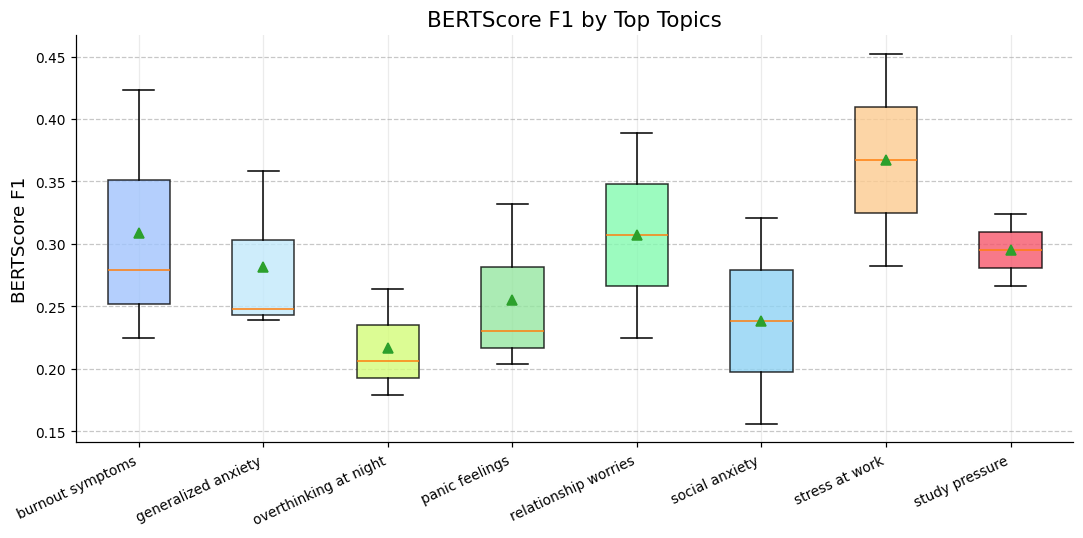

In [54]:
import matplotlib.pyplot as plt
import os


plt.figure(figsize=(10, 5))
box = plt.boxplot(data, labels=top_topics, vert=True, patch_artist=True, showmeans=True)

# Custom boxplot colors
colors = ["#a1c4fd", "#c2e9fb", "#d4fc79", "#96e6a1", "#84fab0", "#8fd3f4", "#fccb90", "#f5576c"]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)

plt.ylabel("BERTScore F1", fontsize=12)
plt.title("BERTScore F1 by Top Topics", fontsize=14)
plt.xticks(rotation=25, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()  # ✅ Show directly in VS Code notebook

# If you still want to save:
# box_path = os.path.join(transcript_dir, "plot_bertscore_by_topic.png")
# plt.savefig(box_path, dpi=160)


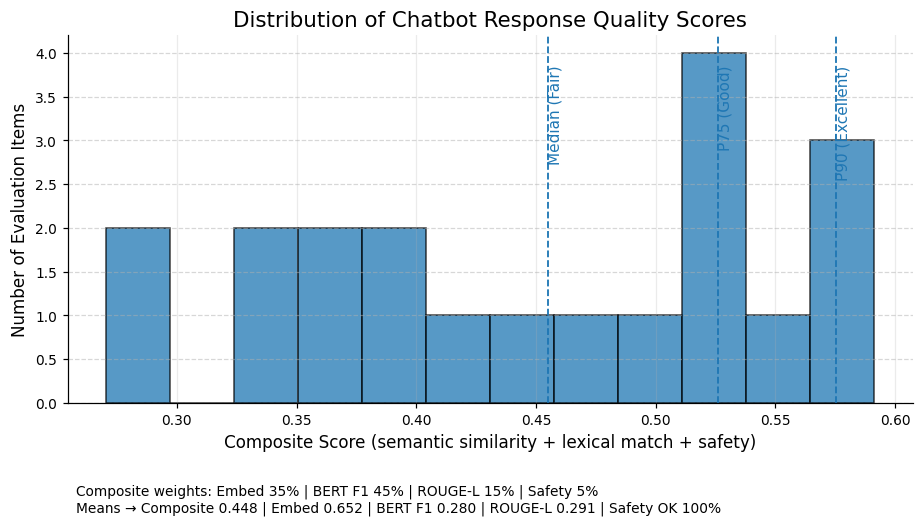

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Quantiles for tier lines
if len(df_eval) >= 5:
    q = np.quantile(df_eval["composite"].astype(float), [0.5, 0.75, 0.9])
else:
    q = np.array([0.4, 0.6, 0.8])  # fallback if small sample

# Weights used in composite calculation
W_EMBED, W_BERT, W_ROUGE, W_SAFETY = 0.35, 0.45, 0.15, 0.05

# Plot histogram
plt.figure(figsize=(8.5, 5))
plt.hist(df_eval["composite"].astype(float).values, bins=12, edgecolor="black", alpha=0.75)

# Add threshold lines and labels
labels = [("Median (Fair)", q[0]), ("P75 (Good)", q[1]), ("P90 (Excellent)", q[2])]
ymax = plt.ylim()[1]
for lab, x in labels:
    plt.axvline(x, linestyle="--", linewidth=1.2, color="tab:blue")
    plt.text(x, ymax * 0.92, lab, rotation=90, va="top", ha="left", color="tab:blue")

# Axis labels and title
plt.xlabel("Composite Score (semantic similarity + lexical match + safety)", fontsize=11)
plt.ylabel("Number of Evaluation Items", fontsize=11)
plt.title("Distribution of Chatbot Response Quality Scores", fontsize=14)

# Stats for legend
mean_comp = float(df_eval["composite"].mean())
mean_sim  = float(df_eval["sim_avg_embed"].mean())
mean_bert = float(pd.to_numeric(df_eval["bertscore_f1"], errors="coerce").mean())
mean_rouge= float(pd.to_numeric(df_eval["rougeL_f"], errors="coerce").mean())
safety_ok_rate = float(df_eval["safety_ok"].mean())

legend_text = (
    f"Composite weights: Embed {int(W_EMBED*100)}% | BERT F1 {int(W_BERT*100)}% | "
    f"ROUGE-L {int(W_ROUGE*100)}% | Safety {int(W_SAFETY*100)}%\n"
    f"Means → Composite {mean_comp:.3f} | Embed {mean_sim:.3f} | "
    f"BERT F1 {mean_bert:.3f} | ROUGE-L {mean_rouge:.3f} | Safety OK {safety_ok_rate:.0%}"
)

plt.annotate(legend_text, xy=(0.01, -0.22), xycoords="axes fraction", fontsize=9, va="top")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


What this chart shows
It’s a histogram of composite scores for your chatbot’s answers.
Think of it as a score report showing how many answers fall into each quality range.

1. X-axis: Composite Score
Ranges from ~0.27 to ~0.60 in your chart.

Higher = better quality answer.

The score is one number combining:

Semantic similarity (35%) → how close in meaning to the correct answer.

BERTScore F1 (45%) → how many key ideas match.

ROUGE-L (15%) → how much wording overlaps.

Safety (5%) → whether it avoids unsafe language.

2. Y-axis: Number of Evaluation Items
How many answers fall into that score range.

Example: The tallest bar near 0.52 means 4 chatbot answers scored in that range.

3. Blue dashed vertical lines
These are performance benchmarks:

Median (Fair) → Half the answers scored below this point (~0.45).

P75 (Good) → Top 25% of answers start here (~0.52).

P90 (Excellent) → Top 10% of answers start here (~0.57).

4. The bars
Each bar groups answers with similar scores.

Left-side bars (0.27–0.40) → lower quality answers.

Middle bars (~0.45–0.52) → average to good answers.

Right-side bars (~0.55–0.59) → excellent answers.

